## 0. Import libraries

In [257]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from torch.optim import Adam
import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


## 1. Load Data

In [258]:
df = pd.read_csv('./total.csv')
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5339,2024-05-17,5303.270020,1346.040039,2412.199951,2724.620117,2742.139893
5340,2024-05-20,5308.129883,1353.390015,2433.899902,2742.139893,2724.179932
5341,2024-05-21,5321.410156,1360.160034,2421.699951,2724.179932,2723.459961
5342,2024-05-22,5307.009766,1363.420044,2389.199951,2723.459961,2721.810059
5343,2024-05-23,5307.009766,1363.420044,2365.199951,2721.810059,2721.810059


In [259]:
col_names = df.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [260]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.95
LR = 1e-4

## 2. Split data train and test

In [261]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# print(df_train.tail())
# print(df_test.head())
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,S&P,currency,gold,kospi,kospi_shift
mean,2.060187e+03,1120.468225,1212.153132,1908.118825,1908.346142
var,1.040263e+06,11179.495861,197490.747079,285130.964445,285101.043571
max,4.796560e+03,1571.400024,2051.500000,3305.209961,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027,719.590027


In [262]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi,kospi_shift
5339,1.122987,0.670873,1.215125,0.775454,0.782230
5340,1.124167,0.681607,1.228067,0.782230,0.775284
5341,1.127390,0.691494,1.220791,0.775284,0.775006
5342,1.123895,0.696255,1.201407,0.775006,0.774367
5343,1.123895,0.696255,1.187094,0.774367,0.774367


In [263]:
class StockDataset(Dataset):
    def __init__(self, data, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        # print(data.shape)
        L = data.shape[0]
        features = data.shape[1] - 1
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        # print(data.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([num_samples, input_window, features])
        Y = np.zeros([num_samples, output_window])
        # print(X.shape, Y.shape)
        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[i, :, :] = data.iloc[start_x:end_x, :-1]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[i, :] = data.iloc[end_x: end_x + output_window, -1:]
        # print(X.shape, Y.shape)
        # X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        # Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

### 3. create dataloader

In [264]:
train_dataset = StockDataset(train_data, 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data, 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
print(a1)

(4948, 128, 4) (4948, 1)
(140, 128, 4) (140, 1)
78 4948 (128, 4) (1,)
(array([[0.09553085, 0.45525181, 0.01663984, 0.03395704],
       [0.09468134, 0.45028624, 0.01723625, 0.03410788],
       [0.0942226 , 0.44663511, 0.01735552, 0.03432446],
       [0.09543376, 0.44312999, 0.01699767, 0.03308297],
       [0.09343863, 0.43524352, 0.01884655, 0.02700317],
       [0.09533183, 0.43655796, 0.01896584, 0.02522024],
       [0.09311826, 0.43232262, 0.0199201 , 0.02620646],
       [0.09284399, 0.42312189, 0.01872728, 0.02902592],
       [0.0957954 , 0.41362896, 0.01777302, 0.0276684 ],
       [0.09650657, 0.41844834, 0.02063578, 0.03345039],
       [0.09502601, 0.42823346, 0.02051651, 0.03966938],
       [0.09674686, 0.42808746, 0.01962189, 0.03527199],
       [0.09707452, 0.43860263, 0.02218644, 0.03113373],
       [0.10015704, 0.43392926, 0.02123219, 0.03399957],
       [0.10003083, 0.44707332, 0.02051651, 0.03543057],
       [0.10106963, 0.45101646, 0.02135147, 0.03285477],
       [0.1018172

## 3. Build a model

In [265]:
class LinearEmbedding(nn.Module):
    def __init__(self, dropout, d_model):
        '''
        data: [batch_size, seq_len, 1]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.linear1 = nn.Linear(1, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, 1]
        output: [batch_size, seq_len, d_model]
        '''
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x

In [266]:
class lstm_encoder(nn.Module):
    def __init__(self, in_ch, input_size, hidden_size, dropout, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.droptout = dropout

        self.conv1d_1 = nn.Conv1d(in_channels=in_ch, out_channels=input_size//2, kernel_size=3, padding=1)
        self.conv1d_2 = nn.Conv1d(in_channels=input_size//2, out_channels=input_size//2, kernel_size=3, padding=1)
        self.conv1d_3 = nn.Conv1d(in_channels=input_size//2, out_channels=input_size, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.emb = LinearEmbedding(dropout, input_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size//2)
        self.linear2 = nn.Linear(hidden_size//2, 1)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x = self.emb(x)
        # [Batch_size, sel_len, ch]
        # print('start:', x.size())
        x = x.transpose(1, 2).contiguous()  # [batch_size, ch, sel_len]
        # print('transpose:',x.size())
        x = self.conv1d_1(x)
        x = self.conv1d_2(x)
        x = self.conv1d_3(x)
        x = x.transpose(1, 2).contiguous()
        # print('after conv1d:',x.size())
        
        lstm_out, self.hidden = self.lstm(x)
        # print(lstm_out[:, -1, :].size())
        x = self.linear1(lstm_out[:, -1, :])
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        # print(x.size())
        return x


## 4. Model, loss_fn, optimizer

In [267]:
batch_size, seq_len, input_dim = next(iter(train_dataloader))[0].size()
print(batch_size, seq_len, input_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_d = 64
dropout = 0.2
n_hidden = 256
n_layers = 1
in_ch = 4
lr = 2e-4
lr_sched = True

64 128 4


In [268]:
model = lstm_encoder(in_ch, model_d, n_hidden, dropout, n_layers).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

## 5. Train and Test

In [269]:
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64])


In [270]:
epochs = 1000
loss_np = np.zeros((epochs, 2))
df_loss = pd.DataFrame(loss_np, columns=['epoch', 'loss'])
for i in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).float()
        labels = labels.squeeze(1).to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output.view(-1).float(), labels.float())
        # print(loss)
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)  # when using scheduler, it is not for grad exploding
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f'epochs: {i}, loss: {epoch_loss:.6f}, lr: ', round(optimizer.param_groups[0]['lr'], 8))
    if lr_sched == True:
        scheduler.step()
    df_loss.loc[i, :] = [i, epoch_loss]

epochs: 0, loss: 2.994948, lr:  0.0002
epochs: 1, loss: 0.381952, lr:  0.0002
epochs: 2, loss: 0.264281, lr:  0.0002
epochs: 3, loss: 0.188859, lr:  0.0002
epochs: 4, loss: 0.129203, lr:  0.0002
epochs: 5, loss: 0.115633, lr:  0.0002
epochs: 6, loss: 0.112338, lr:  0.0002
epochs: 7, loss: 0.117962, lr:  0.0002
epochs: 8, loss: 0.117417, lr:  0.0002
epochs: 9, loss: 0.112260, lr:  0.0002
epochs: 10, loss: 0.113501, lr:  0.0002
epochs: 11, loss: 0.114879, lr:  0.0002
epochs: 12, loss: 0.107393, lr:  0.0002
epochs: 13, loss: 0.109750, lr:  0.0002
epochs: 14, loss: 0.109480, lr:  0.0002
epochs: 15, loss: 0.103486, lr:  0.0002
epochs: 16, loss: 0.103883, lr:  0.0002
epochs: 17, loss: 0.105275, lr:  0.0002
epochs: 18, loss: 0.108031, lr:  0.0002
epochs: 19, loss: 0.108796, lr:  0.0002
epochs: 20, loss: 0.099297, lr:  0.0002
epochs: 21, loss: 0.105313, lr:  0.0002
epochs: 22, loss: 0.099357, lr:  0.0002
epochs: 23, loss: 0.098578, lr:  0.0002
epochs: 24, loss: 0.098334, lr:  0.0002
epochs: 25

In [271]:
save_path = 'lstm_kospi_only_window_inputsize' + str(model_d) + '_hiddensize' + str(n_hidden) + '_seqlen' + str(seq_len) + '_layaers' + str(n_layers)  + '.pt'
# save_path = 'kospi_only.pt'
torch.save(model.state_dict(), save_path)
df_loss

,epoch,loss
0,0.0,2.994948
1,1.0,0.381952
2,2.0,0.264281
3,3.0,0.188859
4,4.0,0.129203
...,...,...
995,995.0,0.026349
996,996.0,0.025271
997,997.0,0.025919
998,998.0,0.025783


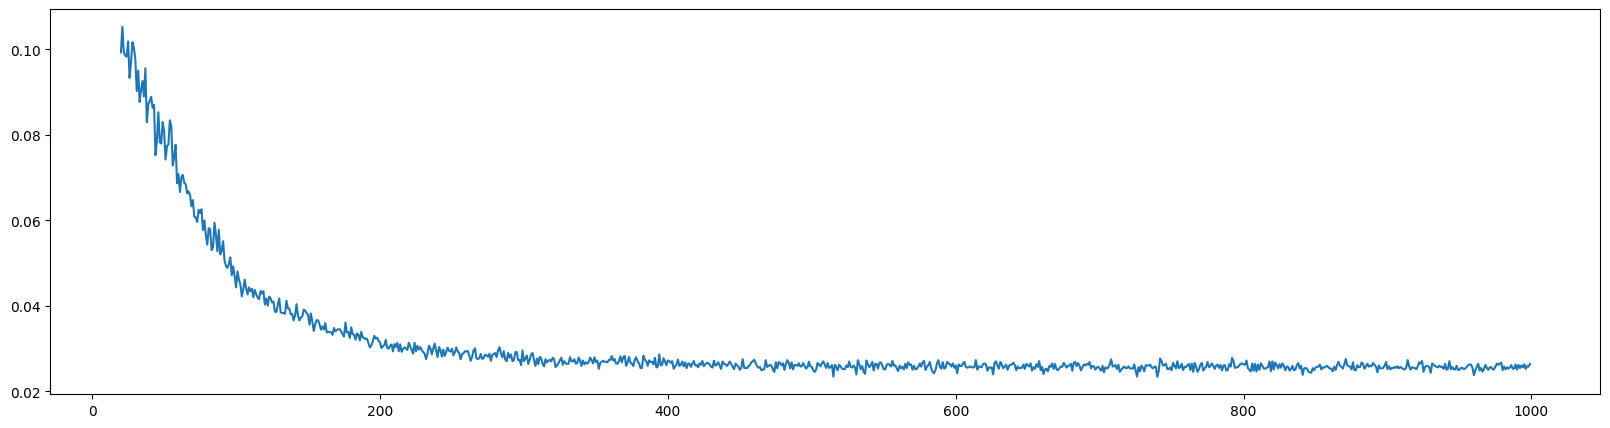

In [272]:
plt.figure(figsize=(20, 5))
plt.plot(df_loss.loc[20: , 'epoch'], df_loss.loc[20: , 'loss'])
plt.show()

In [273]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'kospi']
max = scale_params.loc['max', 'kospi']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0]]
            num += 1

In [274]:
test_result.tail(10)

,pred,pred_rescale,real
130,0.791644,2766.479858,2727.209961
131,0.781165,2739.385216,2730.340088
132,0.776621,2727.635954,2753.000000
133,0.756150,2674.706096,2753.000000
134,0.754560,2670.595850,2724.620117
135,0.797393,2781.344863,2742.139893
136,0.772413,2716.756208,2724.179932
137,0.783943,2746.569901,2723.459961
138,0.771561,2714.554368,2721.810059
139,0.740913,2635.310152,2721.810059


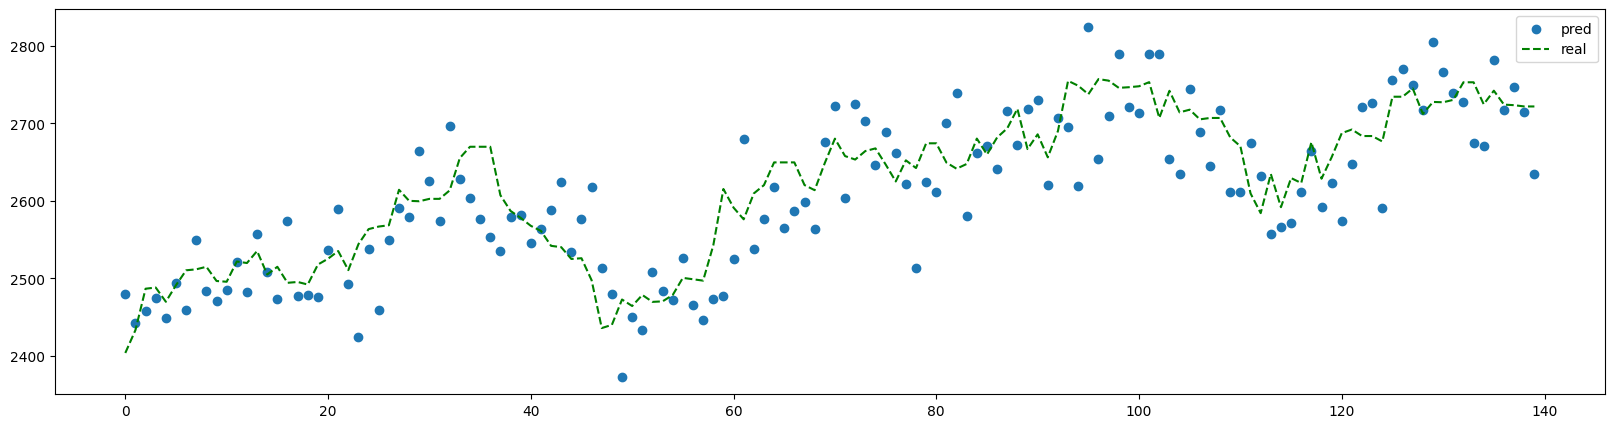

In [275]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

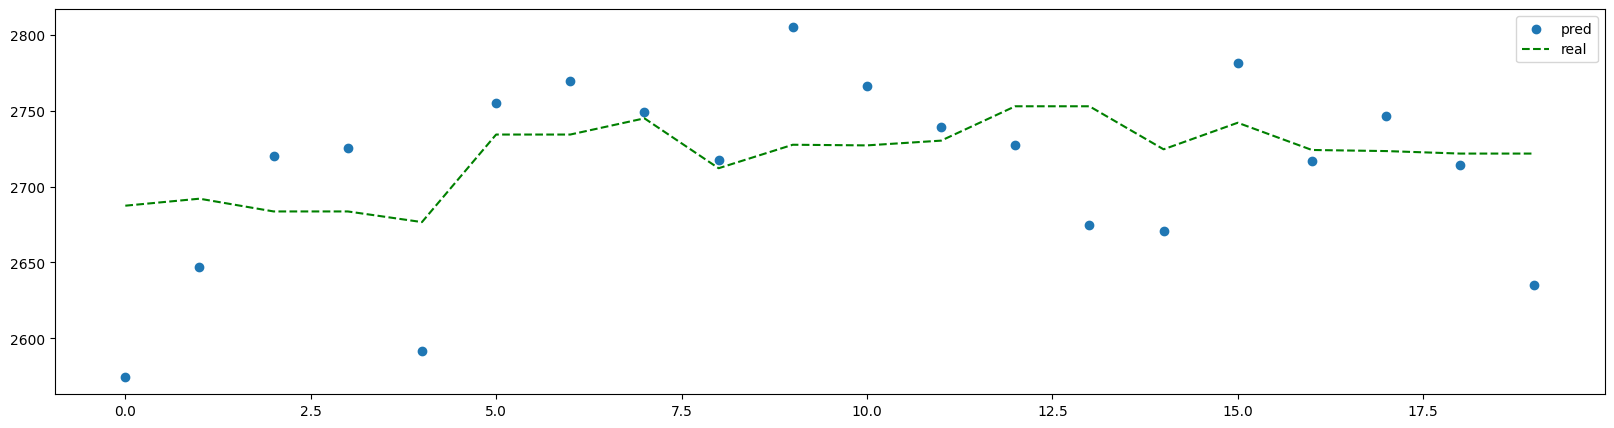

In [276]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

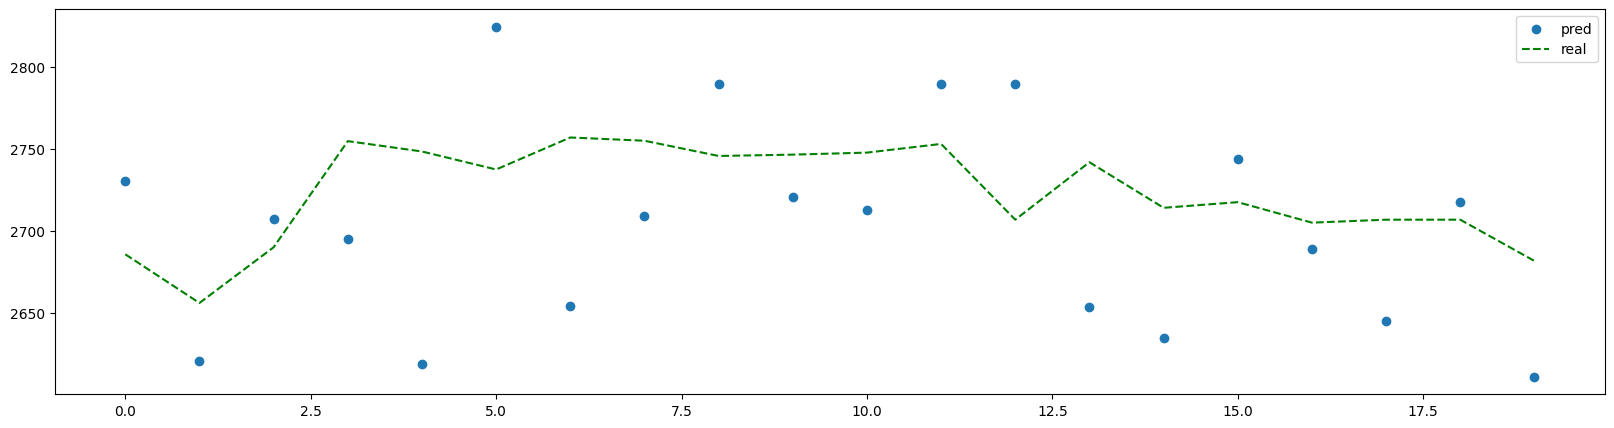

In [277]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

## 6. evaluation metrics
MAPE, MSE

In [278]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 3114.2501, MAPE: 0.0176
